In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from functions import *

In [2]:
socio = pd.read_feather('BF_Dados_Socio_Economicos.feather')
socio = socio.drop_duplicates('identificação')
cont = pd.read_feather('BF_Dados_Contratos.feather')
cont = cont.loc[cont['CONTRATO'] > 40000]
df = cont.join(socio.set_index('identificação'),on = 'IDENTIFICAÇÃO')
df = df.loc[~df['atividade'].isna()]
df['DEFAULT'] = df['ATRASO_DIAS'] > 90
df.loc[df['numero_de_pessoas_na_casa'] > 10,'numero_de_pessoas_na_casa'] = 10
serie = df['numero_de_pessoas_na_casa'].dropna()
df.loc[df['numero_de_pessoas_na_casa'].isna(),'numero_de_pessoas_na_casa'] = np.random.normal(serie.mean(),serie.std(),df['numero_de_pessoas_na_casa'].isna().sum())
df['numero_de_pessoas_na_casa'] = df['numero_de_pessoas_na_casa'].apply(lambda x: round(abs(x)))
df = df.dropna().reset_index(drop = True)
to_drop = ['SITUACAO','QUANTIDADE_PAGAS','ATRASO_DIAS','ATRASO_MAXIMO','RENEGOCIADO','BAIRRO']
df = df.drop(to_drop,axis = 1)

### Clusterização usando k = 6

In [3]:
from sklearn.cluster import Birch,DBSCAN,KMeans,SpectralClustering

In [59]:
clusters = 6
models_group_1 = [KMeans(n_clusters=clusters),Birch(threshold=0.01, n_clusters=clusters)]
models_group_2 = [DBSCAN(eps=0.9, min_samples=20),SpectralClustering(n_clusters=clusters)]

In [60]:
def test_model(df,model):
    df = df.copy()
    new = numerize(df.drop(['CEP','IDENTIFICAÇÃO','CONTRATO','DEFAULT','atividade','melhor_data_vencimento'],axis = 1))
    new = preprocess(new)
    values = new.values
    model.fit(values)
    clusters = model.predict(values)
    df['CLUSTER'] = clusters
    return df[['CLUSTER','DEFAULT']]

def test_model_fit_predict(df,model):
    df = df.copy()
    new = numerize(df.drop(['CEP','IDENTIFICAÇÃO','CONTRATO','DEFAULT','atividade','melhor_data_vencimento'],axis = 1))
    new = preprocess(new)
    values = new.values
    clusters = model.fit_predict(values)
    df['CLUSTER'] = clusters
    return df[['CLUSTER','DEFAULT']]

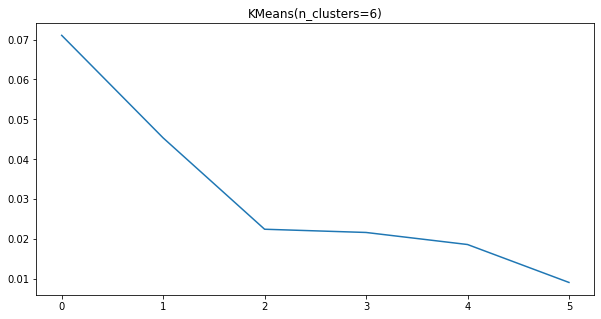

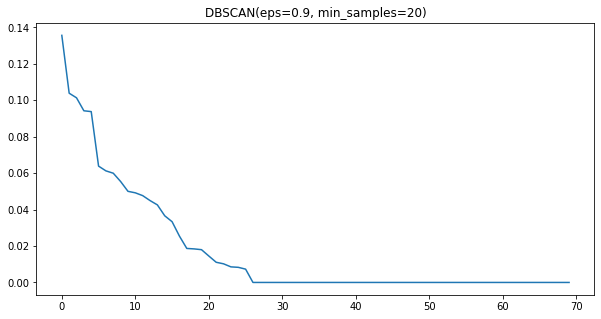

In [61]:
data = []
for model in models_group_1:
    clusters = test_model(df,model)
    group = clusters.groupby('CLUSTER').mean().sort_values(by = 'DEFAULT',ascending = False)
    data.append(clusters)
    plt.figure(figsize = (10,5))
    plt.plot(list(range(len(group))),group.values.ravel())
    plt.title(str(model))
    plt.show()
for model in models_group_2:
    clusters = test_model_fit_predict(df,model)
    group = clusters.groupby('CLUSTER').mean().sort_values(by = 'DEFAULT',ascending = False)
    data.append(clusters)
    plt.figure(figsize = (10,5))
    plt.plot(list(range(len(group))),group.values.ravel())
    plt.title(str(model))
    plt.show()

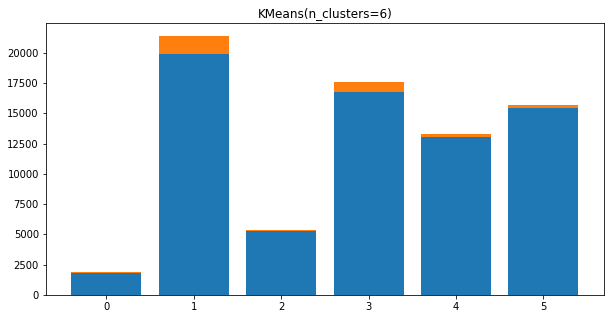

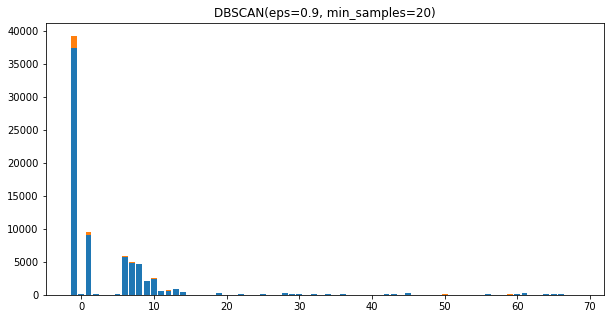

In [62]:
for model,cluster in zip(models_group_1 + models_group_2,data):
    group = pd.concat([cluster.groupby('CLUSTER').sum(),cluster.groupby('CLUSTER').count().rename({'DEFAULT':'CONTAGEM'},axis = 1)],axis = 1)
    group['NOT DEFAULT'] = group['CONTAGEM'] - group['DEFAULT']
    plt.subplots(figsize = (10,5))
    plt.bar(group.index,group['NOT DEFAULT'])
    plt.bar(group.index,group['DEFAULT'],bottom = group['NOT DEFAULT'])
    plt.title(str(model))
    plt.show()

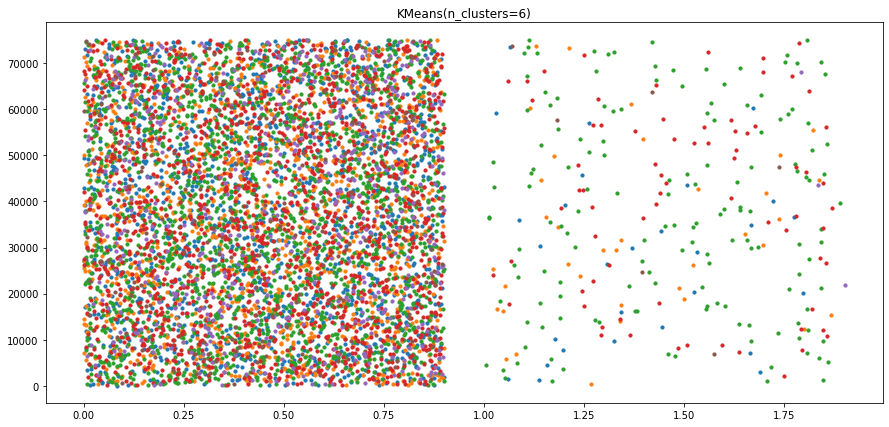

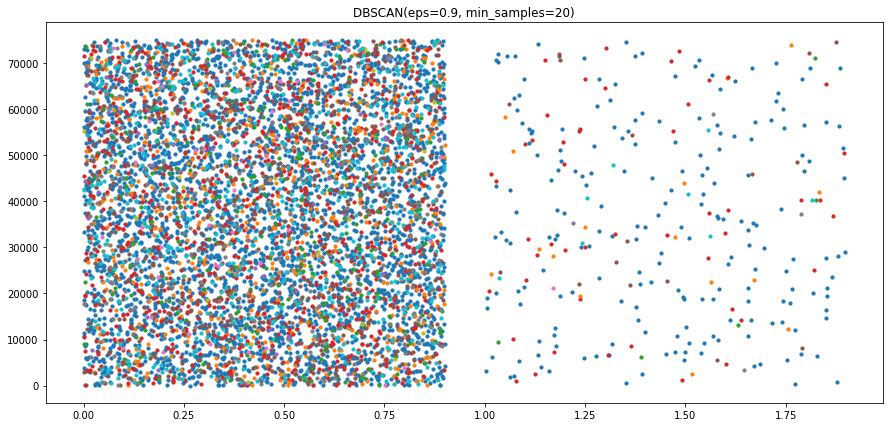

In [63]:
for model,cluster in zip(models_group_1 + models_group_2,data):
    cluster = cluster.sample(frac = 1).reset_index(drop = True)
    unique = cluster['CLUSTER'].unique()
    plt.figure(figsize = (15,7))
    for c in unique:
        filtered = cluster.loc[cluster['CLUSTER'] == c].sample(frac = 0.1)
        plt.scatter(filtered['DEFAULT'].values + (np.random.rand(1,len(filtered)).ravel() * 0.9),filtered.index,s = 10)
    plt.title(str(model))
    plt.show()